<a href="https://colab.research.google.com/github/AhamadAli30/Knee-Osteoarthritis/blob/main/Coronol_detection_using_UNet%2B%2B_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


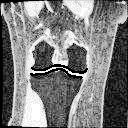

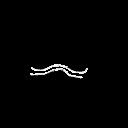

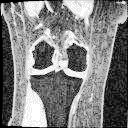

Images overlapped and saved successfully.


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def overlap_images(image1_path, image2_path, output_path):
    # Read the images
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    # Resize image2 to match the size of image1
    image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

    # Create a mask of image2
    mask = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)

    # Invert the mask
    mask_inv = cv2.bitwise_not(mask)

    # Apply the mask to image1
    image1_bg = cv2.bitwise_and(image1, image1, mask=mask_inv)
    cv2_imshow(image1_bg)
    # Apply the mask to image2
    image2_fg = cv2.bitwise_and(image1, image1, mask=cv2.bitwise_not(mask_inv))
    cv2_imshow(image2_fg)
    # Combine the images
    result = cv2.add(image1_bg, image2_fg)

    # Display the overlapped image
    cv2_imshow(result)



    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the overlapped image
    cv2.imwrite(output_path, image1_bg)

    print("Images overlapped and saved successfully.")

# Specify the paths to your input images and output image
image1_path = "/content/drive/MyDrive/coronal/Mild/mild (1).jpg"
image2_path = "/content/drive/MyDrive/coronal_mask/Mild/mild (1).png"
output_path = "/content/drive/MyDrive/coronal/output_image.jpg"

# Call the function to overlap and save the images
overlap_images(image1_path, image2_path, output_path)


In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow

def overlap_images(image_folder, mask_folder, output_folder):
    # Get the list of image and mask files
    image_files = os.listdir(image_folder)
    mask_files = os.listdir(mask_folder)

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Process each image and mask pair
    for image_file, mask_file in zip(image_files, mask_files):
        # Read the image and mask
        image_path = os.path.join(image_folder, image_file)
        mask_path = os.path.join(mask_folder, mask_file)
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize the mask to match the size of the image
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

        # Apply the mask to the image
        result = cv2.bitwise_and(image, image, mask=mask)
        cv2_imshow(result)

        # Save the overlapped image to the output folder
        output_path = os.path.join(output_folder, image_file)
        cv2.imwrite(output_path, result)

    print("Images overlapped and saved successfully.")

# Specify the paths to your input folders and output folder
image_folder = "/content/drive/MyDrive/coronal/Severe"
mask_folder = "/content/drive/MyDrive/coronal_mask/Severe"
output_folder = "/content/drive/MyDrive/coronal_seg/Severe"

# Call the function to overlap and save the images
overlap_images(image_folder, mask_folder, output_folder)


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import os

# Set the path to your dataset
dataset_path = "/content/drive/MyDrive/coronal_seg"

# Define the image size
IMG_HEIGHT = 256
IMG_WIDTH = 256

"""# Define the lower and upper bounds for the articular cartilage intensity
values. These values can be adjusted based on the properties of your
specific images. (105,500)"""
LOWER_BOUND = 105
UPPER_BOUND = 500

# Function for preprocessing the images
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0 # Normalize pixel values
    img = np.uint8(img * 255) # Convert image to 8-bit unsigned integer format
    img = np.expand_dims(img, axis=-1)
    return img

# Create a list of image paths and their corresponding labels
image_paths = []
labels = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

# Preprocess the images and store them in a list
preprocessed_images = []

for image_path in image_paths:
    preprocessed_image = preprocess_image(image_path)
    preprocessed_images.append(preprocessed_image)

# Convert the labels to numerical values
label_dict = {"Mild": 0,"Moderate": 1, "Normal": 2, "Severe": 3}
numerical_labels = [label_dict[label] for label in labels]

# Convert the preprocessed images and numerical labels to numpy arrays
X = np.array(preprocessed_images)
y = np.array(numerical_labels)


# Create a new list to store the segmented images
segmented_images = []

# Loop through each image and perform segmentation
for i in range(len(X)):
    img = X[i]
    # Apply a threshold to isolate the articular cartilage region
    _, thresh = cv2.threshold(img, LOWER_BOUND, UPPER_BOUND, cv2.THRESH_BINARY)


    #Apply morphological operations to remove noise and fill gaps in the articular cartilage region

    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    # Apply a mask to retain only the articular cartilage region
    masked_img = np.zeros_like(img)
    masked_img[closing == 255] = img[closing == 255]

    # Create a binary mask
    mask = np.zeros_like(masked_img)
    mask[masked_img > 0] = 1

    # Apply the mask to the image
    masked_img = masked_img * mask

    # Add the segmented image to the list
    segmented_images.append(masked_img)

# Convert the list of segmented images to a numpy array
X = np.array(segmented_images)

#print(labels[11])

print(X.shape)

(258, 256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

# Convert the labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

def conv_block(inputs, filters, kernel_size=3, padding='same', activation='relu'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    return x

def encoder_block(inputs, filters, kernel_size=3, padding='same', activation='relu'):
    conv = conv_block(inputs, filters, kernel_size, padding, activation)
    pool = tf.keras.layers.MaxPooling2D()(conv)
    return conv, pool

def decoder_block(inputs, skip, filters, kernel_size=3, padding='same', activation='relu'):
    x = tf.keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(inputs)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, filters, kernel_size, padding, activation)
    return x

def UnetPlusPlus(input_shape):
    # Encoder
    inputs = Input(shape=input_shape)
    #inputs = tf.keras.layers.Input(shape=input_shape)
    s1 = inputs
    e1, p1 = encoder_block(s1, 32)
    e2, p2 = encoder_block(p1, 64)
    e3, p3 = encoder_block(p2, 128)
    e4, p4 = encoder_block(p3, 256)

    # Center
    c = conv_block(p4, 512)

    # Decoder
    u4 = decoder_block(c, e4, 256)
    u3 = decoder_block(u4, e3, 128)
    u2 = decoder_block(u3, e2, 64)
    u1 = decoder_block(u2, e1, 32)

    flat=tf.keras.layers.Flatten()(u1)
    # Output
    outputs = tf.keras.layers.Dense(4, activation='sigmoid')(flat)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='UnetPlusPlus')
    return model

# Instantiate the model
model = UnetPlusPlus(input_shape=(256,256, 1))

# Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

# Print the model summary
model.summary()
print(X_train.shape)

Model: "UnetPlusPlus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/10
12/12 [==============================] - 45s 976ms/step - loss: 20.6359 - accuracy: 0.3778 - val_loss: 146.7487 - val_accuracy: 0.3704
Epoch 2/10
12/12 [==============================] - 4s 344ms/step - loss: 7.6575 - accuracy: 0.6000 - val_loss: 58.3786 - val_accuracy: 0.2963
Epoch 3/10
12/12 [==============================] - 4s 348ms/step - loss: 1.9656 - accuracy: 0.8389 - val_loss: 26.7531 - val_accuracy: 0.3519
Epoch 4/10
12/12 [==============================] - 4s 317ms/step - loss: 0.9830 - accuracy: 0.9778 - val_loss: 21.6022 - val_accuracy: 0.2963
Epoch 5/10
12/12 [==============================] - 4s 345ms/step - loss: 0.8144 - accuracy: 0.9500 - val_loss: 18.9271 - val_accuracy: 0.2963
Epoch 6/10
12/12 [==============================] - 4s 350ms/step - loss: 0.4034 - accuracy: 0.9667 - val_loss: 18.8153 - val_accuracy: 0.3704
Epoch 7/10
12/12 [==============================] - 4s 351ms/step - loss: 0.1336 - accuracy: 0.9722 - val_loss: 16.3435 - val_accuracy: 0.3

In [ ]:
loss = model.evaluate(X_train, y_train)
print('Test Loss:', loss)

6/6 [==============================] - 5s 1s/step - loss: 0.1270 - accuracy: 0.9722
Test Loss: [0.12699583172798157, 0.9722222089767456]


In [ ]:
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)

2/2 [==============================] - 0s 67ms/step - loss: 15.4514 - accuracy: 0.4359
Test Loss: [15.451447486877441, 0.43589743971824646]


In [ ]:
loss = model.evaluate(X_val, y_val)
print('Test Loss:', loss)

2/2 [==============================] - 0s 64ms/step - loss: 17.3807 - accuracy: 0.3846
Test Loss: [17.38066291809082, 0.38461539149284363]


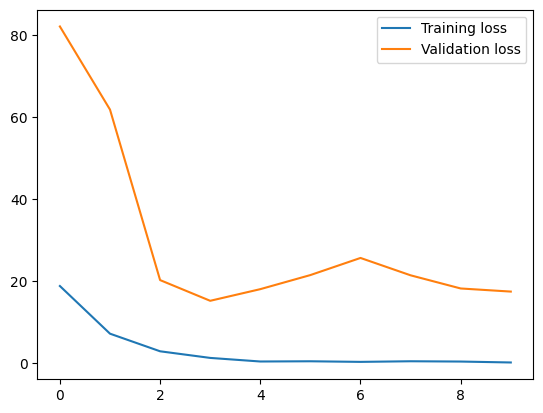

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.legend()
plt.show()

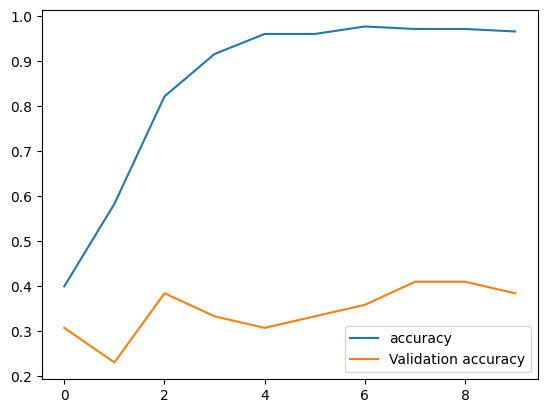

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')

plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

In [ ]:
#sets to 1 for the labels wihich are not predicted
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
y_true = [label_dict[label] for label in labels]
y_pred = np.argmax(model.predict(X), axis=-1)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 score: {f1:.2%}")


9/9 [==============================] - 11s 303ms/step
Accuracy: 80.23%
Precision: 80.67%
Recall: 80.23%
F1 score: 80.10%


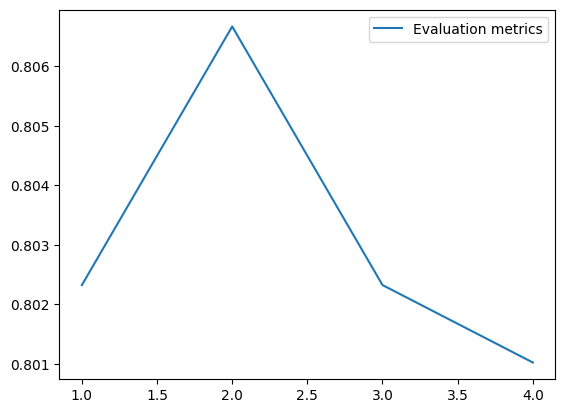

In [ ]:
import matplotlib.pyplot as plt

plt.plot([1, 2, 3, 4], [accuracy, precision, recall, f1], label='Evaluation metrics')
plt.legend()
plt.show()


In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model on the test set
y_pred = model.predict(X_test)

# Convert the predicted labels from one-hot encoded vectors to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert the true labels from one-hot encoded vectors to class labels
y_true_labels = np.argmax(y_test, axis=1)

# Compute evaluation metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average="weighted")
recall = recall_score(y_true_labels, y_pred_labels, average="weighted")
f1 = f1_score(y_true_labels, y_pred_labels, average="weighted")

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

2/2 [==============================] - 0s 254ms/step
Accuracy: 51.28%
Precision: 47.56%
Recall: 51.28%
F1 score: 48.84%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
